## Project Understanding.
### DonorsChoose
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

## Problem 
Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
- How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible
- How to increase the consistency of project vetting across different volunteers to improve the experience for teachers
- How to focus volunteer time on the applications that need the most assistance

### Obective 
- The objective here is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school.

In [204]:
# Importing everything.
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
# from collections import Counter
plt.figure(figsize=(15,8))

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

### Getting Data

In [205]:
project_df = pd.read_csv('train_data.csv')
desc_df = pd.read_csv('resources.csv')

In [206]:
project_df.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [207]:
desc_df.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [208]:
print('train_data.csv has {} rows and {} columns'.format(project_df.shape[0], project_df.shape[1]))
print('resource.csv has {} rows and {} columns'.format(desc_df.shape[0], desc_df.shape[1]))
pr_features = list(project_df.columns)
des_features = list(desc_df.columns)
print("---------------------------------------------")
print("Features in train_data.csv: ")
print(pr_features)
print("Total number of features {}".format(len(pr_features)))
print("---------------------------------------------")
print("Features in resource.csv: ")
print(des_features)
print("Total number of features {}".format(len(des_features)))

train_data.csv has 109248 rows and 17 columns
resource.csv has 1541272 rows and 4 columns
---------------------------------------------
Features in train_data.csv: 
['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state', 'project_submitted_datetime', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4', 'project_resource_summary', 'teacher_number_of_previously_posted_projects', 'project_is_approved']
Total number of features 17
---------------------------------------------
Features in resource.csv: 
['id', 'description', 'quantity', 'price']
Total number of features 4


In [209]:
approved_projects = project_df[project_df['project_is_approved'] == 1]
print("Number of projects approved: {} ({} %)".format(len(approved_projects), len(approved_projects) / len(project_df) * 100))
print("Number of projects disapproved: {} ({} %)".format(len(project_df) - len(approved_projects), (len(project_df) - len(approved_projects))/len(project_df)*100))

Number of projects approved: 92706 (84.85830404217927 %)
Number of projects disapproved: 16542 (15.141695957820739 %)


### Performing univariate analysis:

- #### School State:

In [210]:
school_projects = project_df.groupby('school_state')['project_is_approved'].apply(np.mean)


In [211]:
school_projects=school_projects.reset_index()

In [212]:
school_projects.sort_values(by='project_is_approved', inplace=True, ascending=False)

In [213]:
school_projects['project_is_approved'] = school_projects['project_is_approved']*100

In [214]:
np.mean(school_projects['project_is_approved'])

84.81205441795778

In [215]:
print('5 Highest approvals: ')
print(school_projects.head())
print('-------------------------')
print('5 Lowest approvals: ')
print(school_projects.tail())

5 Highest approvals: 
   school_state  project_is_approved
8            DE            89.795918
28           ND            88.811189
47           WA            87.617823
35           OH            87.515201
30           NH            87.356322
-------------------------
5 Lowest approvals: 
   school_state  project_is_approved
18           LA            83.124478
26           MT            81.632653
43           TX            81.314224
7            DC            80.232558
46           VT            80.000000


In [216]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

Every state has more than or equal to 80% rate of approval.

In [217]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_df.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_df.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_df.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

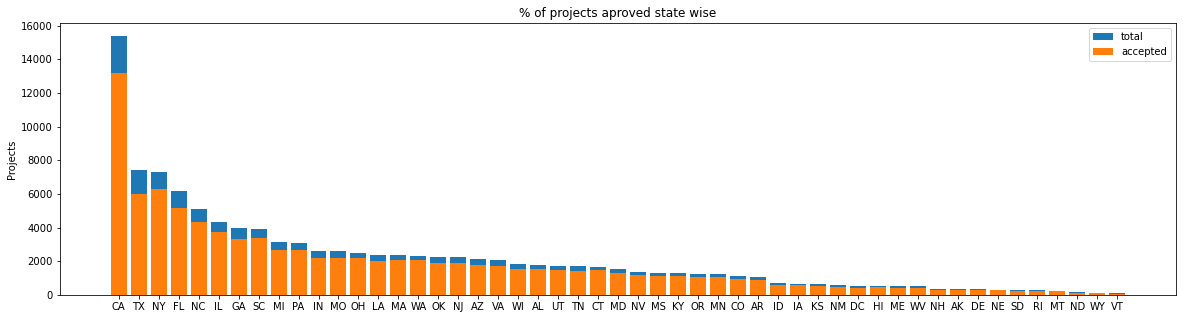

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [218]:
univariate_barplots(project_df, 'school_state', 'project_is_approved', False)

- #### Teacher Prefix 

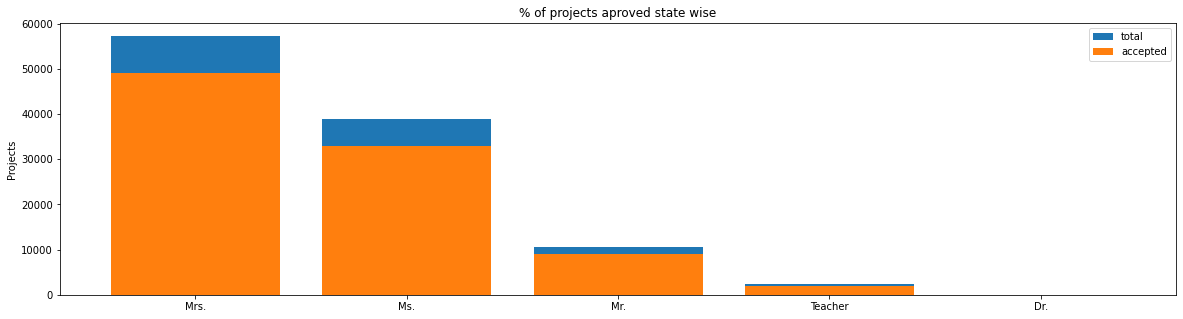

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [219]:
univariate_barplots(project_df, 'teacher_prefix', 'project_is_approved' , top=False)

As we can see here there are many projects submitted by teacher with prefix Mrs.
Dr.s submits less number of projects.

- #### Project grade category

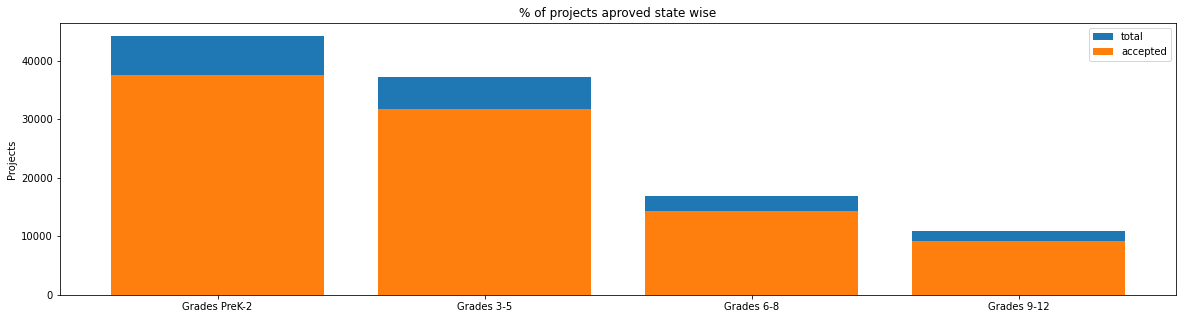

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [220]:
univariate_barplots(project_df, 'project_grade_category', 'project_is_approved', top=False)

- #### project_subject_categories

In [221]:
type(project_df['project_subject_categories'].values)

numpy.ndarray

In [222]:
type(list(project_df['project_subject_categories']))

list

In [223]:
#split by comma
#remove the
#remove spaces
#remove trailing spaces
#replace &
categories = list(project_df['project_subject_categories'].values)

cat_list = []

for i in categories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j=j.replace(' ','')
        temp+=j.strip()+" "
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())

In [224]:
project_df['clean_categories'] = cat_list
project_df.drop(['project_subject_categories'], inplace=True, axis=1)
project_df.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,Literacy_Language Math_Science
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,Math_Science


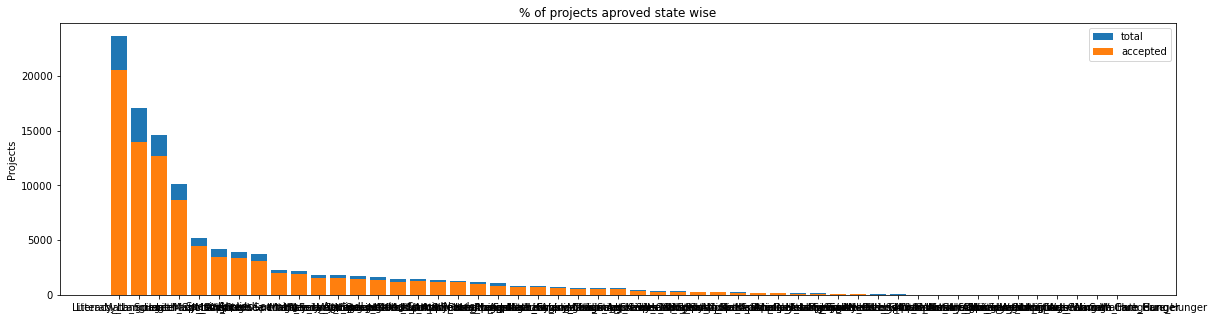

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                        clean_categories  project_is_approved  total       Avg
41            Music_Arts AppliedLearning                    7     10  0.700000
7     AppliedLearning Warmth Care_Hunger                    8     10  0.800000
31  Literacy_Language Warmth Care_Hunger                    7      9  0.777778
45         Music_Arts Warmth Care_Hunger                    1      2  0.500000
23     History_Civics Warmth Care_Hunger                    0      1  0.000000


In [225]:
univariate_barplots(project_df, 'clean_categories', 'project_is_approved',top=False)

- Literacy_Language has a very high rate of applications and project approval.

In [226]:
from collections import Counter
my_counter = Counter()
for word in project_df['clean_categories'].values:
    my_counter.update(word.split())

In [227]:
my_counter

Counter({'Literacy_Language': 52239,
         'History_Civics': 5914,
         'Health_Sports': 14223,
         'Math_Science': 41421,
         'SpecialNeeds': 13642,
         'AppliedLearning': 12135,
         'Music_Arts': 10293,
         'Warmth': 1388,
         'Care_Hunger': 1388})

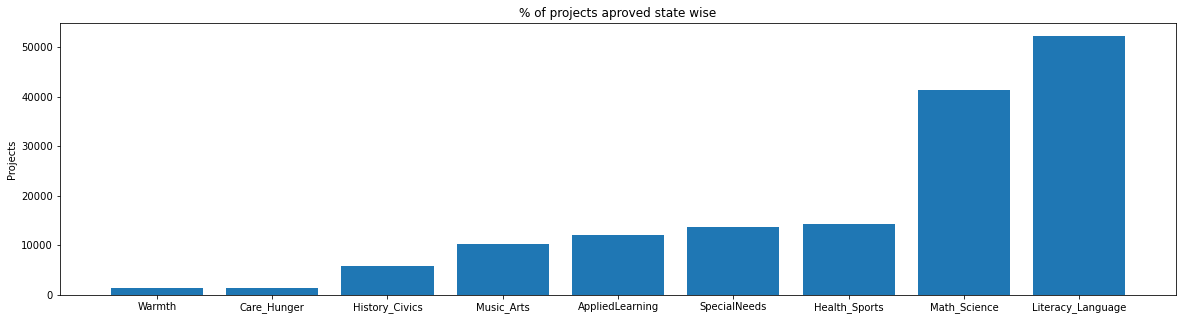

In [228]:
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [229]:
for i, j in sorted_cat_dict.items():
    print("{:20} : {:10}".format(i,j))

Warmth               :       1388
Care_Hunger          :       1388
History_Civics       :       5914
Music_Arts           :      10293
AppliedLearning      :      12135
SpecialNeeds         :      13642
Health_Sports        :      14223
Math_Science         :      41421
Literacy_Language    :      52239


In [230]:
#split by comma
#remove the
#remove spaces
#remove trailing spaces
#replace &
sub_categories = list(project_df['project_subject_subcategories'].values)

sub_cat_list = []

for i in sub_categories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The', '')
        j=j.replace(' ','')
        temp+=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
    
project_df['clean_sub_categories'] = sub_cat_list
project_df.drop(['project_subject_subcategories'], inplace=True, axis=1)
project_df.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_sub_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,Health_Sports,Health_Wellness TeamSports
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1,Literacy_Language Math_Science,Literacy Mathematics
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1,Math_Science,Mathematics


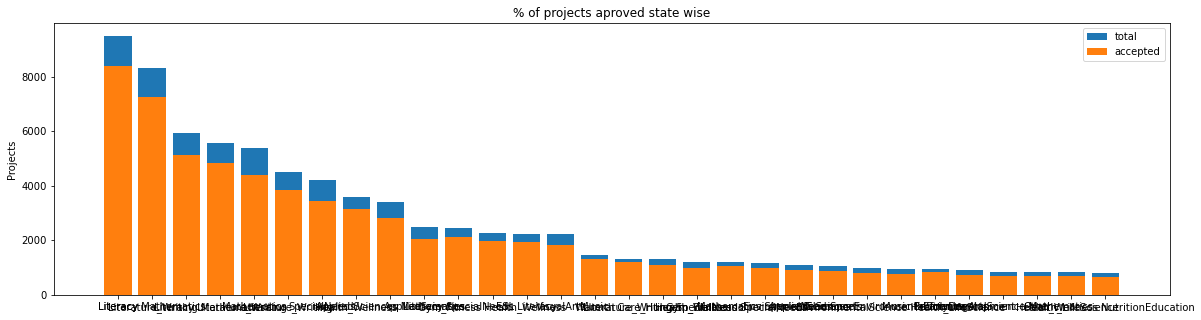

               clean_sub_categories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                   clean_sub_categories  project_is_approved  total       Avg
150                    EarlyDevelopment                  740    905  0.817680
198    EnvironmentalScience Mathematics                  683    838  0.815036
368                               Other                  701    831  0.843562
273                  Health_LifeScience                  701    827  0.847642
295  Health_Wellness NutritionEducation                  667    797  0.836888


In [232]:
univariate_barplots(project_df, 'clean_sub_categories', 'project_is_approved',top=30)

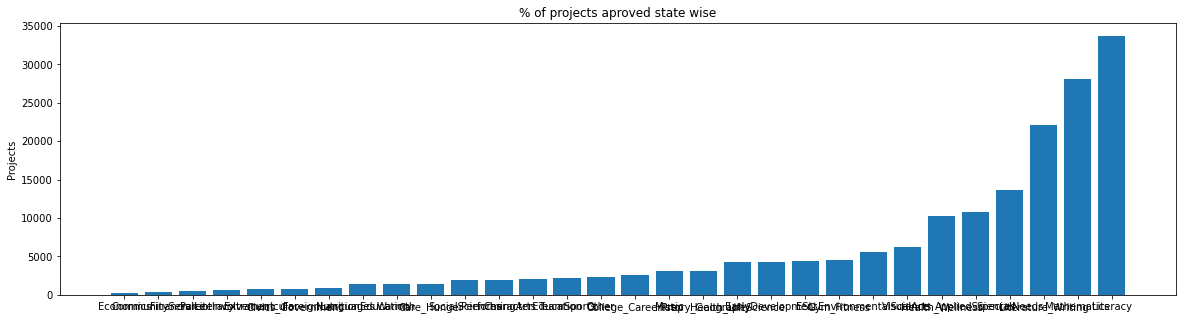

In [234]:
from collections import Counter
my_counter = Counter()
for word in project_df['clean_sub_categories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [235]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} : {:10}".format(i,j))

Economics            :        269
CommunityService     :        441
FinancialLiteracy    :        568
ParentInvolvement    :        677
Extracurricular      :        810
Civics_Government    :        815
ForeignLanguages     :        890
NutritionEducation   :       1355
Warmth               :       1388
Care_Hunger          :       1388
SocialSciences       :       1920
PerformingArts       :       1961
CharacterEducation   :       2065
TeamSports           :       2192
Other                :       2372
College_CareerPrep   :       2568
Music                :       3145
History_Geography    :       3171
Health_LifeScience   :       4235
EarlyDevelopment     :       4254
ESL                  :       4367
Gym_Fitness          :       4509
EnvironmentalScience :       5591
VisualArts           :       6278
Health_Wellness      :      10234
AppliedSciences      :      10816
SpecialNeeds         :      13642
Literature_Writing   :      22179
Mathematics          :      28074
Literacy      